In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import os
import matplotlib
from river import cluster
from river import stream
from river import preprocessing
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

In [10]:
root_dir ="/Users/marcos/GitHubRepos/BioStatisticsDataDive/DataDive"
data_dir = root_dir+ "/data/processed/concatenated_data_csv/split_0/"

In [11]:
def get_train(data_dir):
    train = pd.read_csv(data_dir + "betas_train.csv")
    train_se = pd.read_csv(data_dir + "se_train.csv").iloc[:, 1:-2]
    train_betas = train.iloc[:, 1:-2]
    train_betas = train_betas.div(train_se.rename(columns={train_se.columns[i]:train_betas.columns[i] for i in range(train_betas.shape[1])}, inplace=False), axis=0)
    true_train_cluster_indices = train.iloc[:, -1].astype(int)
    true_train_unique_clusters = np.array(sorted(true_train_cluster_indices.unique())).flatten()
    n_classes = true_train_unique_clusters.shape[0]
    true_train_cluster_centers = np.array([train_betas[true_train_cluster_indices == c].mean(axis=0) for c in true_train_unique_clusters]).reshape(n_classes, train_betas.shape[-1])
    # Use the new colormap interface (Matplotlib ≥ 3.7)
    cmap = matplotlib.colormaps.get_cmap('tab10').resampled(n_classes)
    # Assign a unique color to each unique label
    color_dict = {label: cmap(i) for i, label in enumerate(true_train_unique_clusters)}
    colors = np.array([color_dict[label] for label in true_train_cluster_indices])
    return train_betas, true_train_cluster_indices, true_train_unique_clusters, true_train_cluster_centers, colors

def get_val(data_dir):
    val = pd.read_csv(data_dir + "betas_validate.csv")
    val_se = pd.read_csv(data_dir + "se_validate.csv").iloc[:, 1:-2]
    val_betas = val.iloc[:, 1:-2]
    val_betas = val_betas.div(val_se.rename(columns={val_se.columns[i]:train_betas.columns[i] for i in range(val_betas.shape[1])}, inplace=False), axis=0)
    val_betas=val_betas.div(val_betas.abs().sum(axis="columns"), axis=0)
    val_cluster_indices = val.iloc[:, -1].astype(int)
    return val_betas, val_cluster_indices

def visualise_train_betas(train_betas, colors):
    for k in range(train_betas.shape[0]):
        plt.scatter(np.arange(1, train_betas.shape[1]+1), train_betas.iloc[k, :],color=colors[k], s=5)
    plt.xlabel("Variant ID")
    plt.ylabel("Regression Coefficient Against Trait")
    plt.show()
    plt.close()
    plt.scatter(np.arange(1, train_betas.shape[0]+1), train_betas.abs().sum(axis=1), s=5)
    plt.xlabel("Experiment ID")
    plt.ylabel("Mean Absolute Beta Vector")
    plt.show()
    plt.close()

def plot_aris(inc_aris, full_aris):
    plt.scatter(np.arange(len(inc_aris)), inc_aris,s=10, label="Incremental")
    plt.scatter(np.arange(len(full_aris)), full_aris, s=10,label="Full")
    plt.xlabel("Number of Validation Points")
    plt.legend()
    plt.ylabel("ARI")

# Stream in the data one point at a time
def streaming_kmeans(train_betas, val_betas, train_centroids, train_cluster_indices, train_unique_clusters,true_train_unique_clusters, true_train_cluster_indices, num_train_samples_per_cluster, true_val_cluster_indices):
    inc_clusters = []
    inc_train_centroids = train_centroids
    inc_aris = []
    full_aris = []
    for k, row in val_betas.iterrows():
        cidx = np.argmin(np.sum(np.power(inc_train_centroids - row.to_numpy().reshape(1, -1),2), axis=-1)).item()
        inc_clusters.append(cidx)
        inc_aris.append(adjusted_rand_score(np.concatenate([train_cluster_indices, inc_clusters]), np.concatenate([true_train_cluster_indices, true_val_cluster_indices.iloc[:k+1]])))

        # Update the centroid
        num_train_samples_per_cluster[cidx] += 1
        inc_train_centroids[cidx, :] += (row.to_numpy()-inc_train_centroids[cidx, :]) / num_train_samples_per_cluster[cidx]

        full_unique_clusters = np.unique(np.concatenate([true_train_cluster_indices.to_numpy().flatten(), true_val_cluster_indices[:k+1].to_numpy().flatten()]))
        try:
            # If original uses ground truths
            assert (full_unique_clusters == true_train_unique_clusters).all()
        except AssertionError:
            # if original from scratch
            assert (full_unique_clusters == train_unique_clusters).all()

        n_full_unique_clusters = full_unique_clusters.shape[0]
        full_kmeans = KMeans(n_clusters=n_full_unique_clusters, random_state=42, n_init='auto')
        assert (val_betas.iloc[k,:] == row).all()
        full_kmeans.fit(pd.concat([train_betas, val_betas.iloc[:k+1, :]], axis=0))
        full_aris.append(adjusted_rand_score(full_kmeans.labels_, np.concatenate([train_cluster_indices, true_val_cluster_indices.iloc[:k+1]])))

    print(np.array(inc_aris).shape, np.array(full_aris).shape)
    print(f"Incremental vs Full ARI: {inc_aris}, {full_aris}")
    return inc_aris, full_aris

In [12]:
def kmeans_from_scratch(data_dir, true_train_unique_clusters, true_train_cluster_indices, train_betas):
    val_betas, true_val_cluster_indices = get_val(data_dir=data_dir)
    # Create an online KMeans model
    kmeans = KMeans(n_clusters=true_train_unique_clusters.shape[0], random_state=42, n_init='auto')
    kmeans.fit(train_betas)

    # Get cluster centroids
    train_centroids = kmeans.cluster_centers_
    train_cluster_indices = kmeans.labels_
    train_unique_clusters = np.unique(train_cluster_indices)
    num_train_samples_per_cluster = {c.item(): np.sum(train_cluster_indices == c).item() for c in np.unique(train_cluster_indices)}
    train_ari = adjusted_rand_score(train_cluster_indices, true_train_cluster_indices)
    print(f"Train ARI: {train_ari}")
    inc_aris, full_aris = streaming_kmeans(train_betas=train_betas,val_betas=val_betas, train_centroids=train_centroids, train_cluster_indices=train_cluster_indices, train_unique_clusters=train_unique_clusters, num_train_samples_per_cluster=num_train_samples_per_cluster, true_val_cluster_indices=true_val_cluster_indices, true_train_unique_clusters=true_train_unique_clusters, true_train_cluster_indices=true_train_cluster_indices)
    plot_aris(inc_aris=inc_aris, full_aris=full_aris)


In [13]:
# Try initialising with the true clusters
def kmeans_with_true_grounds(data_dir, train_betas, true_train_cluster_centers, true_train_cluster_indices, true_train_unique_clusters):
    val_betas, true_val_cluster_indices = get_val(data_dir=data_dir)

    # Get cluster centroids
    train_centroids = true_train_cluster_centers
    train_cluster_indices = true_train_cluster_indices
    num_train_samples_per_cluster = {c.item(): np.sum(train_cluster_indices == c).item() for c in np.unique(train_cluster_indices)}
    train_ari = adjusted_rand_score(train_cluster_indices, true_train_cluster_indices)
    print(f"Train ARI: {train_ari}")
    inc_aris, full_aris = streaming_kmeans(train_betas=train_betas,val_betas=val_betas, train_centroids=train_centroids, train_cluster_indices=train_cluster_indices, train_unique_clusters=true_train_unique_clusters, num_train_samples_per_cluster=num_train_samples_per_cluster, true_val_cluster_indices=true_val_cluster_indices, true_train_unique_clusters=true_train_unique_clusters, true_train_cluster_indices=true_train_cluster_indices)
    plot_aris(inc_aris=inc_aris, full_aris=full_aris)

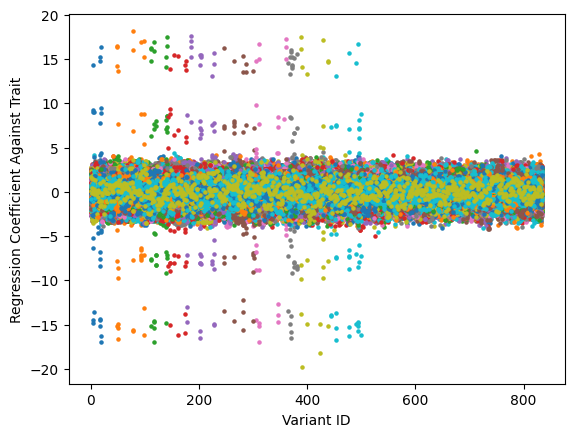

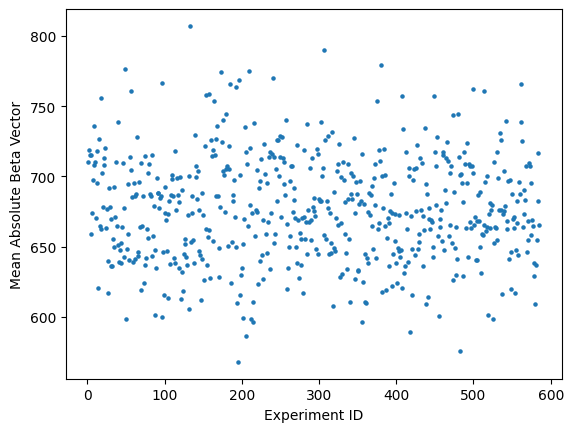

In [14]:
train_betas, true_train_cluster_indices, true_train_unique_clusters, true_train_cluster_centers, colors = get_train(data_dir=data_dir)
visualise_train_betas(train_betas=train_betas, colors=colors)

Train ARI: 1.0
(195,) (195,)
Incremental vs Full ARI: [0.9955198246493564, 0.991078873045743, 0.986867267842615, 0.9821236828610114, 0.9766766238489053, 0.9716582150014614, 0.9666900595930535, 0.961227681596646, 0.9560045547499336, 0.9499506956865865, 0.9441461701137361, 0.9389512144077221, 0.933108112279706, 0.9273356081583309, 0.920993004007325, 0.9152030264176978, 0.9091586592280952, 0.903031319991583, 0.8967026701555418, 0.8906205538319819, 0.8839687703509923, 0.8775646499131934, 0.8713998657142179, 0.8642872106519791, 0.8575765386506106, 0.8510145212775332, 0.8447446890422459, 0.8380551013921428, 0.8312479111434647, 0.8240950929663474, 0.8175889867406005, 0.8109798176700569, 0.803907409833955, 0.797140586951107, 0.7907360124434811, 0.7838265342351923, 0.7767336975298489, 0.7696467319973803, 0.7624530923123124, 0.7551617722569589, 0.7480042152292422, 0.7410862329641972, 0.734760634743229, 0.7281254612406366, 0.7213319474639813, 0.7145631177828308, 0.7078434013865909, 0.701225435282

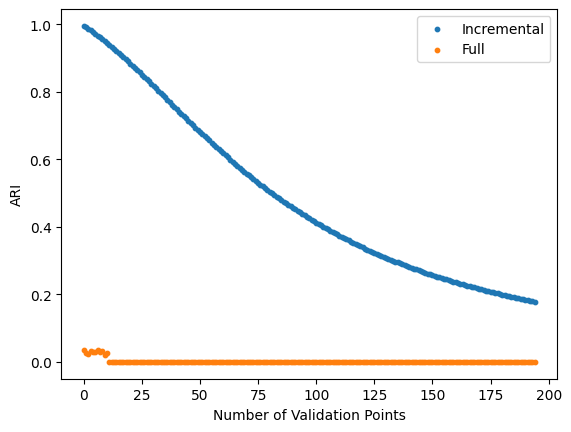

In [15]:
kmeans_with_true_grounds(data_dir=data_dir,train_betas=train_betas, true_train_cluster_centers=true_train_cluster_centers, true_train_cluster_indices=true_train_cluster_indices, true_train_unique_clusters=true_train_unique_clusters)

Train ARI: 0.025867739794313588
(195,) (195,)
Incremental vs Full ARI: [0.02584677840250019, 0.02582919780396482, 0.02554173954347348, 0.02522836843772949, 0.024878971264933075, 0.02455865632224205, 0.024522720650680563, 0.024183536251391146, 0.023862606014057104, 0.02349707046339007, 0.02315016426225939, 0.023089328088517665, 0.023012221446102644, 0.02293958500067469, 0.022810310924345847, 0.022476641291366638, 0.02238942870098792, 0.022040584566513907, 0.021915069477266135, 0.022057269356770787, 0.021679841817805863, 0.021321464958987305, 0.020981883269392567, 0.020583440510534443, 0.020213960809544084, 0.020075855930312785, 0.020412221976687187, 0.020282001617925455, 0.02011969972306353, 0.02018749404270198, 0.020295591222831522, 0.020368372191948772, 0.019969572054992425, 0.020023411741528895, 0.020322816400925876, 0.02013057530359648, 0.019725136203458213, 0.019539499084914886, 0.019342545481375758, 0.018919984550351043, 0.018508480899371564, 0.018327756612810532, 0.01835428774967

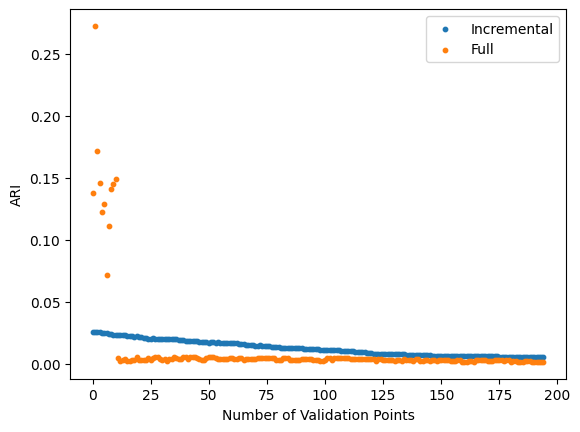

In [16]:
kmeans_from_scratch(data_dir=data_dir,true_train_unique_clusters=true_train_unique_clusters, true_train_cluster_indices=true_train_cluster_indices, train_betas=train_betas)